In [2]:
from google.colab import files
uploaded = files.upload()

Saving New Data.csv to New Data (4).csv


In [3]:
import io
import pandas as pd
df = pd.read_csv(io.BytesIO(uploaded['New Data.csv'])) # Dataset is now stored in a Pandas Dataframe

print(df.head())

   Id                                           Judgment  Judgment Status
0   1  appeal judgment decree bombay high court stone...                1
1   2  application article 32 1 constitution enforcem...                2
2   3  appeal judgment high court hyderabad article 3...                0
3   4  appeal article 3744 constitution judgment decr...                0
4   5  petitions art 136 constitution praying special...                3


In [4]:
sentences = df[['Judgment','Judgment Status']]

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(sentences,  test_size=0.25, random_state=42)

In [5]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['Judgment Status'])
y_test = to_categorical(df_test['Judgment Status'])

In [6]:
import transformers
from transformers import AutoTokenizer,TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=df_train.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [8]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [10]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [11]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss=loss, 
    metrics = metric)

In [12]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=10,
    batch_size=64
)

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 373s 81s/step - loss: 1.8082 - balanced_accuracy: 0.3417 - val_loss: 1.2721 - val_balanced_accuracy: 0.3875
Epoch 2/10
4/4 [==============================] - 325s 82s/step - loss: 1.2742 - balanced_accuracy: 0.4625 - val_loss: 1.2933 - val_balanced_accuracy: 0.3500
Epoch 3/10
4/4 [==============================] - 325s 84s/step - loss: 1.2233 - balanced_accuracy: 0.4083 - val_loss: 1.2695 - val_balanced_accuracy: 0.4000
Epoch 4/10
4/4 [==============================] - 323s 82s/step - loss: 1.1614 - balanced_accuracy: 0.5125 - val_loss: 1.2616 - val_balanced_accuracy: 0.4375
Epoch 5/10
4/4 [==============================] - 322s 82s/step - loss: 1.0537 - balanced_accuracy: 0.5625 - val_loss: 1.2547 - val_balanced_accuracy: 0.4250
Epoch 6/10
4/4 [==============================] - 320s 81s/step - loss: 1.0061 - balanced_accuracy: 0.6125 - val_loss: 1.2517 - val_balanced_accuracy: 0.4375
Epoch 7/10
4/4 [==============================] - 306s 78s/step

In [13]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

3/3 [==============================] - 53s 12s/step


array([0.5597546 , 0.87066644, 0.30986446, 0.14373852], dtype=float32)

In [14]:
import numpy as np

y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Judgment Status']

In [15]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_predicted))

print(accuracy_score(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.50      0.46      0.48        24
           1       0.46      0.59      0.52        29
           2       0.33      0.27      0.30        11
           3       0.67      0.50      0.57        16

    accuracy                           0.49        80
   macro avg       0.49      0.45      0.47        80
weighted avg       0.50      0.49      0.49        80

0.4875


In [19]:
x_train ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9750


In [20]:
x_test = {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.4875


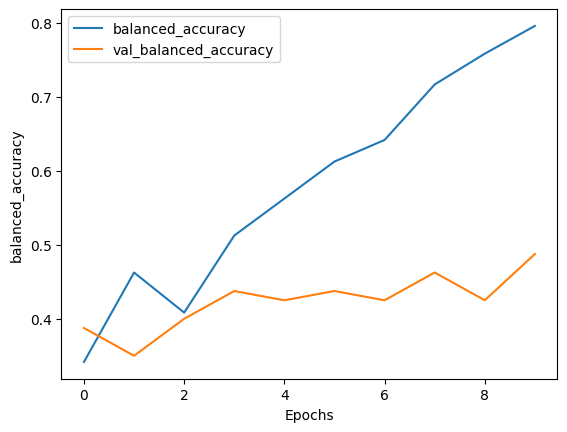

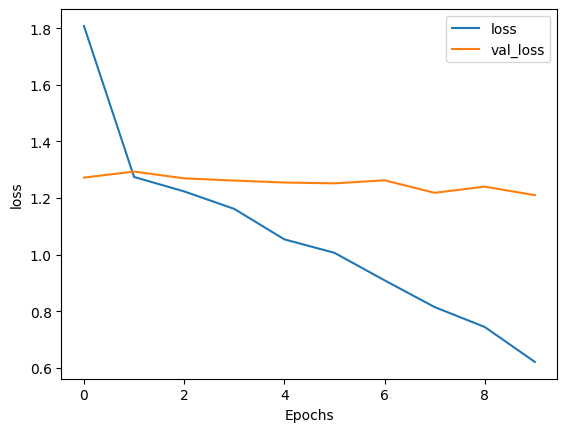

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(train_history, "balanced_accuracy")
plot_graphs(train_history, "loss")